Accuracy: 0.9481233119120798
F1 Score: 0.9481256077081911


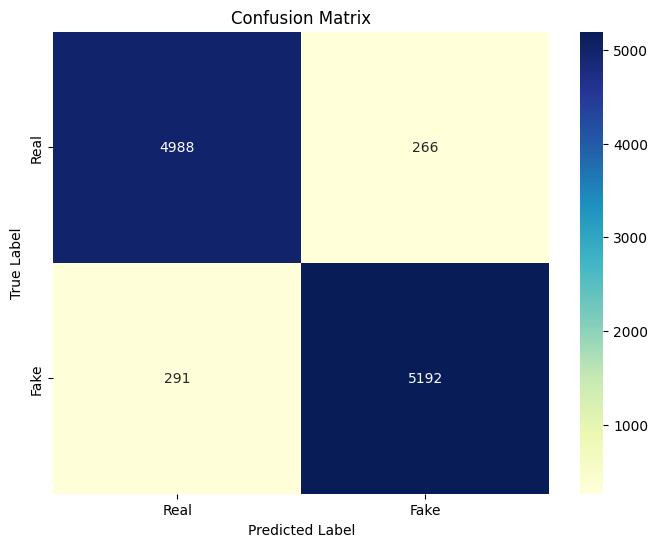

In [3]:
import os
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from fakenews.model.model import BERTClass
from fakenews.config import BEST_MODEL, PROCESSED_DATA_DIR
from fakenews.data.preprocessing import DataPreprocessor

# Clear any existing Hydra instance
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()

# Initialize Hydra and load the configuration
initialize(config_path="../config", version_base="1.2")
cfg = compose(config_name="config")

# Load the preprocessed test data
preprocessor = DataPreprocessor(data_dir=PROCESSED_DATA_DIR, max_length=cfg.preprocess.max_length)
_, _, test_dataloader = preprocessor.process(
    batch_size=cfg.train.batch_size,
    test_size=cfg.train.test_size,
    val_size=cfg.train.val_size,
    random_state=cfg.train.random_state,
    processed_data_dir=PROCESSED_DATA_DIR,
)

# Load the trained model from the best model path
model_checkpoint_path = os.path.join(BEST_MODEL, "model.ckpt")
model = BERTClass.load_from_checkpoint(model_checkpoint_path, cfg=cfg)

# Determine the device (CPU, GPU, MPS)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Move model to the device
model.to(device)
model.eval()

# Predict on the test data
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        sent_id, mask, labels = batch
        sent_id, mask = sent_id.to(device), mask.to(device)
        outputs = model(sent_id=sent_id, mask=mask)
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average="weighted")
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()